## Comparison of LSTM Models 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import csv 
import sys
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Input, Flatten, Dropout

from statsmodels.tools.eval_measures import rmse
from tabulate import tabulate

Using TensorFlow backend.


## Discussion 

With a bigger dataset, we want to compare the best type of LSTM model for our data. The following analyzes: 
1. Vanilla LSTM 
2. Stacked LSTM 
3. Bidirectional LSTM 

In [2]:
covid19_us = pd.read_csv("../data/covid19_US.csv")
covid19_us.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
covid19_us = covid19_us.set_index("Date")
covid19_us

,Confirmed
Date,
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5
...,...
5/13/20,1390406
5/14/20,1417774
5/15/20,1442824


We want a 3 day look ahead for our LSTM 

In [3]:
train_data = covid19_us[:len(covid19_us)-3]
test_data = covid19_us[len(covid19_us)-3:]

Scale each feature between zero and one 

In [4]:
scalar = MinMaxScaler()
scalar.fit(train_data)
scaled_train_data = scalar.transform(train_data)
scaled_test_data = scalar.transform(test_data)

In [5]:
steps = 3
n_features = 1 
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = steps, batch_size=1)

## 1. Apply Vanilla LSTM 

In [6]:
model_vanilla = Sequential()
model_vanilla.add(LSTM(200, activation="relu", input_shape=(steps, n_features)))
model_vanilla.add(Dense(1))
model_vanilla.compile(optimizer="adam", loss="mse")

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model_vanilla.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_vanilla.fit_generator(generator, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0542
Epoch 2/20
111/111 [==============================] - 0s 4ms/step - loss: 2.0952e-04
Epoch 3/20
111/111 [==============================] - 0s 3ms/step - loss: 1.3404e-04
Epoch 4/20
111/111 [==============================] - 1s 5ms/step - loss: 1.1669e-04
Epoch 5/20
111/111 [==============================] - 1s 6ms/step - loss: 5.2294e-05
Epoch 6/20
111/111 [==============================] - 1s 5ms/step - loss: 3.9941e-05
Epoch 7/20
111/111 [==============================] - 1s 5ms/step - loss: 4.1247e-05
Epoch 8/20
111/111 [==============================] - 0s 4ms/step - loss: 3.9512e-05
Epoch 9/20
111/111 [==============================] - 0s 4ms/step - loss: 3.8386e-05
Epoch 10/20
111/111 [==============================] - 0s 4ms/step - loss: 3.0688e-05
Epoch 11/20
111/111 [==============================] - 0s 3ms/step - loss: 1.4870e-04
Epoch 12/20
111/111

In [9]:
losses_vanilla = model_vanilla.history.history["loss"]

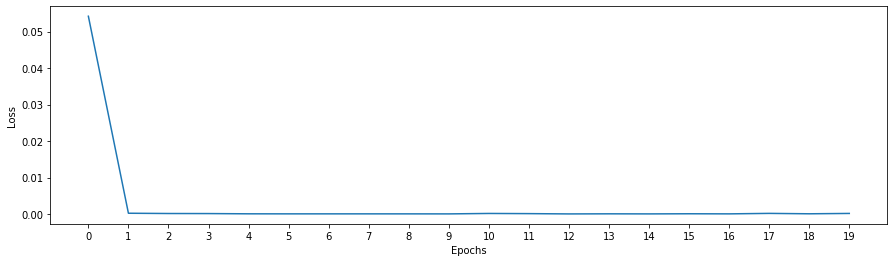

In [10]:
plt.figure(figsize=(15,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_vanilla)), losses_vanilla)

In [11]:
prediction_scaled_vanilla = list()

batch = scaled_train_data[-steps:]
curr_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)): 
    pred_vanilla = model_vanilla.predict(curr_batch)[0]
    prediction_scaled_vanilla.append(pred_vanilla)
    curr_batch = np.append(curr_batch[:, 1:, :], [[pred_vanilla]], axis=1)

In [12]:
prediction_scaled_vanilla

[array([1.0210174], dtype=float32),
 array([1.038995], dtype=float32),
 array([1.0590122], dtype=float32)]

In [13]:
prediction_vanilla = scalar.inverse_transform(prediction_scaled_vanilla)
prediction_vanilla

array([[1447571.94792068],
       [1473060.09718347],
       [1501439.86782813]])

#### Let's see how we did 

In [14]:
test_data["LSTM_Predictions"] = prediction_vanilla
test_data

,Confirmed,LSTM_Predictions
Date,,
5/15/20,1442824,1.447572e+06
5/16/20,1467820,1.473060e+06
5/17/20,1486757,1.501440e+06


Not bad results 

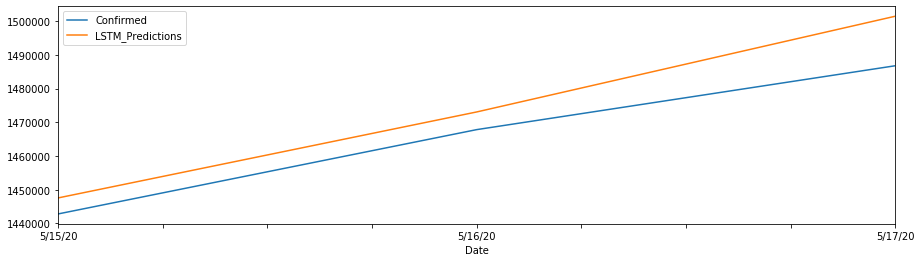

In [15]:
test_data['Confirmed'].plot(figsize = (15,4), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [16]:
lstm_rmse_error_vanilla = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_vanilla = lstm_rmse_error_vanilla**2
mean_value = covid19_us['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_vanilla, '\nRMSE Error:', lstm_rmse_error_vanilla, '\nMean:',mean_value)

MSE Error: 88529411.869338 
RMSE Error: 9409.006954473889 
Mean: 364899.452991453


## 2. Apply Stacked LSTM 


In [17]:
model_stacked = Sequential()
model_stacked.add(LSTM(200, activation="relu", input_shape=(steps, n_features), return_sequences=True))
model_stacked.add(LSTM(200, activation="relu"))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer="adam", loss="mse")

In [18]:
model_stacked.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 200)            161600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_stacked.fit_generator(generator, epochs=20)

Epoch 1/20
111/111 [==============================] - 1s 12ms/step - loss: 0.0483
Epoch 2/20
111/111 [==============================] - 1s 7ms/step - loss: 7.3781e-04
Epoch 3/20
111/111 [==============================] - 1s 7ms/step - loss: 1.5513e-04
Epoch 4/20
111/111 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 5/20
111/111 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 6/20
111/111 [==============================] - 1s 6ms/step - loss: 5.4870e-04
Epoch 7/20
111/111 [==============================] - 1s 6ms/step - loss: 1.3800e-04
Epoch 8/20
111/111 [==============================] - 1s 7ms/step - loss: 2.0217e-04
Epoch 9/20
111/111 [==============================] - 1s 7ms/step - loss: 1.7391e-04
Epoch 10/20
111/111 [==============================] - 1s 7ms/step - loss: 8.6904e-05
Epoch 11/20
111/111 [==============================] - 1s 6ms/step - loss: 6.5811e-05
Epoch 12/20
111/111 [==============================] - 1s 7ms/step - loss:

In [20]:
losses_stacked = model_stacked.history.history["loss"]

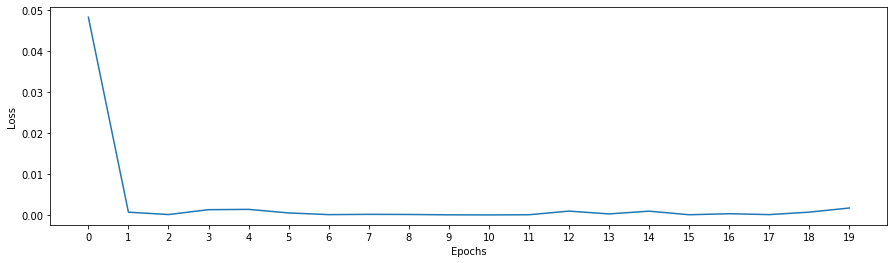

In [21]:
plt.figure(figsize=(15,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_stacked)), losses_stacked)

In [22]:
prediction_scaled_stacked = list()

batch = scaled_train_data[-steps:]
curr_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)): 
    pred_stacked = model_stacked.predict(curr_batch)[0]
    prediction_scaled_stacked.append(pred_stacked)
    curr_batch = np.append(curr_batch[:, 1:, :], [[pred_stacked]], axis=1)

In [23]:
prediction_scaled_stacked

[array([0.97141176], dtype=float32),
 array([0.9804436], dtype=float32),
 array([0.98264664], dtype=float32)]

In [24]:
prediction_stacked = scalar.inverse_transform(prediction_scaled_stacked)
prediction_stacked

array([[1377242.37176305],
       [1390047.4596225 ],
       [1393170.88056749]])

#### Let's see how we did 

In [25]:
test_data["LSTM_Predictions"] = prediction_stacked 
test_data

,Confirmed,LSTM_Predictions
Date,,
5/15/20,1442824,1.377242e+06
5/16/20,1467820,1.390047e+06
5/17/20,1486757,1.393171e+06


Not bad results 

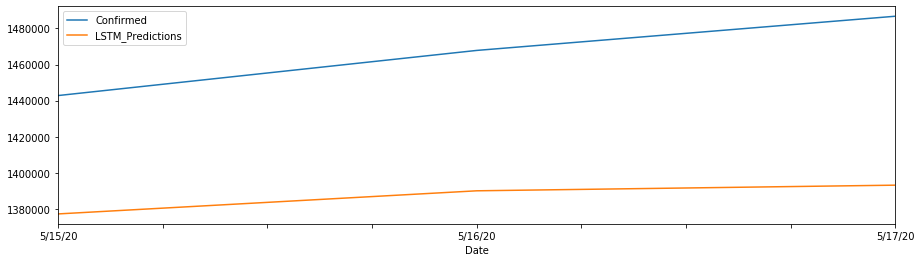

In [26]:
test_data['Confirmed'].plot(figsize = (15,4), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [27]:
lstm_rmse_error_stacked = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_stacked = lstm_rmse_error_stacked**2
mean_value = covid19_us['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_stacked, '\nRMSE Error:', lstm_rmse_error_stacked, '\nMean:',mean_value)

MSE Error: 6369293249.804927 
RMSE Error: 79807.85205607858 
Mean: 364899.452991453


## 3. Apply Bidirectional LSTM 

In [28]:
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(steps, n_features)))
model_bidirectional.add(Dense(1))
model_bidirectional.compile(optimizer='adam', loss='mse')

In [29]:
model_bidirectional.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 400)               323200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 323,601
Trainable params: 323,601
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_bidirectional.fit_generator(generator, epochs=20)

Epoch 1/20
111/111 [==============================] - 1s 12ms/step - loss: 0.0333
Epoch 2/20
111/111 [==============================] - 1s 6ms/step - loss: 9.2712e-05
Epoch 3/20
111/111 [==============================] - 1s 6ms/step - loss: 9.5158e-05
Epoch 4/20
111/111 [==============================] - 1s 6ms/step - loss: 6.7563e-05
Epoch 5/20
111/111 [==============================] - 1s 6ms/step - loss: 5.6398e-05
Epoch 6/20
111/111 [==============================] - 1s 5ms/step - loss: 3.3670e-05
Epoch 7/20
111/111 [==============================] - 1s 6ms/step - loss: 5.5378e-05
Epoch 8/20
111/111 [==============================] - 1s 6ms/step - loss: 2.5133e-05
Epoch 9/20
111/111 [==============================] - 1s 6ms/step - loss: 3.3628e-05
Epoch 10/20
111/111 [==============================] - 1s 6ms/step - loss: 2.5944e-05
Epoch 11/20
111/111 [==============================] - 1s 5ms/step - loss: 4.7772e-05
Epoch 12/20
111/111 [==============================] - 1s 6ms/step

In [31]:
losses_bidirectional = model_bidirectional.history.history["loss"]

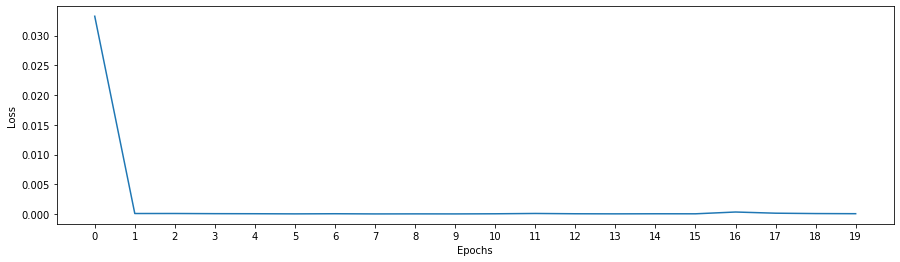

In [32]:
plt.figure(figsize=(15,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_bidirectional)), losses_bidirectional)

In [33]:
prediction_scaled_bidirectional = list()

batch = scaled_train_data[-steps:]
curr_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)): 
    pred_bidirectional = model_bidirectional.predict(curr_batch)[0]
    prediction_scaled_bidirectional.append(pred_bidirectional)
    curr_batch = np.append(curr_batch[:, 1:, :], [[pred_bidirectional]], axis=1)

In [34]:
prediction_scaled_bidirectional

[array([1.0192795], dtype=float32),
 array([1.0370665], dtype=float32),
 array([1.0560063], dtype=float32)]

In [35]:
prediction_bidirectional = scalar.inverse_transform(prediction_scaled_bidirectional)
prediction_bidirectional

array([[1445107.92617035],
       [1470325.82570553],
       [1497178.23750818]])

In [36]:
test_data["LSTM_Predictions"] = prediction_bidirectional
test_data

,Confirmed,LSTM_Predictions
Date,,
5/15/20,1442824,1.445108e+06
5/16/20,1467820,1.470326e+06
5/17/20,1486757,1.497178e+06


Not bad results 

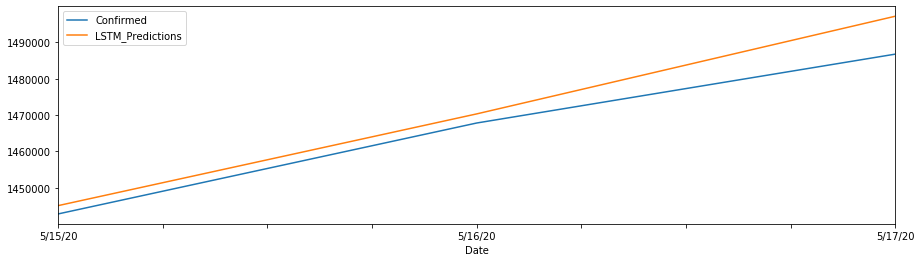

In [37]:
test_data['Confirmed'].plot(figsize = (15,4), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [38]:
lstm_rmse_error_bidirectional = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_bidirectional = lstm_rmse_error_bidirectional**2
mean_value = covid19_us['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_bidirectional, '\nRMSE Error:', lstm_rmse_error_bidirectional, '\nMean:',mean_value)



MSE Error: 40032557.47331425 
RMSE Error: 6327.128691066292 
Mean: 364899.452991453


### Discussion 

Would adding a dropout improve accuracy? Before we had a small dataset and drop out would in fact decrease accuracy significantly 

In [39]:
print(tabulate([
    ['Vanilla LSTM', lstm_mse_error_vanilla, lstm_rmse_error_vanilla], 
    ['Stacked LSTM', lstm_mse_error_stacked, lstm_rmse_error_stacked],
    ['Bidirectional LSTM', lstm_mse_error_bidirectional, lstm_rmse_error_bidirectional]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))

Model                       MSE      RMSE
------------------  -----------  --------
Vanilla LSTM        8.85294e+07   9409.01
Stacked LSTM        6.36929e+09  79807.9
Bidirectional LSTM  4.00326e+07   6327.13
